In [24]:
import os
from os import listdir
from os.path import isfile, join
import sys
from xml.etree import ElementTree
from xml.etree.ElementTree import Element, SubElement
from lxml import etree
import codecs
import cv2
XML_EXT = '.xml'
ENCODE_METHOD = "UTF8"
from google.colab import drive
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score


In [2]:
#Mounting to the google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
class PascalVocReader:

    def __init__(self, file_path):
        # shapes type:
        # [labbel, [(x1,y1), (x2,y2), (x3,y3), (x4,y4)], color, color, difficult]
        self.shapes = []
        self.file_path = file_path
        self.verified = False
        try:
            self.parse_xml()
        except:
            pass

    def get_shapes(self):
        return self.shapes

    def add_shape(self, label, bnd_box, difficult):
        x_min = int(float(bnd_box.find('xmin').text))
        y_min = int(float(bnd_box.find('ymin').text))
        x_max = int(float(bnd_box.find('xmax').text))
        y_max = int(float(bnd_box.find('ymax').text))
        points = [(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)]
        self.shapes.append((label, points, None, None, difficult))

    def parse_xml(self):
        assert self.file_path.endswith(XML_EXT), "Unsupported file format"
        parser = etree.XMLParser(encoding=ENCODE_METHOD)
        xml_tree = ElementTree.parse(self.file_path, parser=parser).getroot()
        filename = xml_tree.find('filename').text
        try:
            verified = xml_tree.attrib['verified']
            if verified == 'yes':
                self.verified = True
        except KeyError:
            self.verified = False

        for object_iter in xml_tree.findall('object'):
            bnd_box = object_iter.find("bndbox")
            label = object_iter.find('name').text
            # Add chris
            difficult = False
            if object_iter.find('difficult') is not None:
                difficult = bool(int(object_iter.find('difficult').text))
            self.add_shape(label, bnd_box, difficult)
        return True
# font = cv2.FONT_HERSHEY_SIMPLEX
# color=(0,0,255)
# annotations=r"/content/drive/My Drive/400/Annotation/HCM/train"     #Annotations folder
# images=r"/content/drive/My Drive/400/HCM/train"     #Images folder
# results=r"/content/drive/My Drive/results"     #Folder where you want to store results

# files=[f for f in listdir(annotations)if isfile(join(annotations,f))]

# for f in files:
#     xml_path=join(annotations,f)
#     thickness=0
#     resolution=f.split('_')[-1].split('.')[0]
#     if resolution=="1000x":
#         thickness=33
#     elif resolution=="400x":
#         thickness=14
#     else:
#         thickness=3
# #     print(f)
#     img_name=f.split('x')[0]+'x.png'
#     img_path=join(images,img_name)
# #     print(img_path)
#     # print(xml_path)
#     img=cv2.imread(img_path)
#     t_voc_parse_reader = PascalVocReader(xml_path)
#     shapes = t_voc_parse_reader.get_shapes()
#     # print(len(shapes))
#     for s in shapes:
#         org=s[1][0]
#         org=(org[0], org[1]-8)
#         color=(0,0,255)
#         if s[0]=="ring":
#             color=(0,0,255)
#         elif s[0]=="trophozoite":
#             color=(255,0,0)
#         elif s[0]=="schizont":
#             color=(0,255,0)
#         else:
#             color=(0,0,0)
# # you can add the label on each boundary box plotted.
# #         img = cv2.putText(img, s[0], org, font,
# #                     1, color, 2, cv2.LINE_AA)
#         cv2.rectangle(img,s[1][0],s[1][2],color,thickness)

#     cv2.imwrite(join(results,img_name),img)


In [26]:
# Define DataLoader Class
class MalariaDataset(Dataset):
    class_mapping = {"ring": 0, "trophozoite": 1, "schizont": 2, "gametocyte": 3}  # Map class labels to integers

    def __init__(self, root_dir, mode='classification', transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.image_folder = os.path.join(root_dir, 'HCM', 'train')
        self.annotation_folder = os.path.join(root_dir, 'Annotation', 'HCM', 'train')
        self.image_files = [f for f in os.listdir(self.image_folder) if os.path.isfile(os.path.join(self.image_folder, f))]
        self.labels = self._load_labels()

    def _load_labels(self):
        labels = {}
        for filename in os.listdir(self.annotation_folder):
            if filename.endswith('.xml'):
                label = self._parse_annotation_file(os.path.join(self.annotation_folder, filename))
                image_name = filename.split('.')[0] + 'x.png'
                labels[image_name] = label
        return labels

    def _parse_annotation_file(self, filepath):
        voc_reader = PascalVocReader(filepath)
        shapes = voc_reader.get_shapes()
        num_classes = len(self.class_mapping)
        label = np.zeros(num_classes)  # Initialize label as all zeros
        for s in shapes:
            class_index = self.class_mapping.get(s[0], -1)  # Get the index of the class label
            if class_index != -1:
                label[class_index] = 1  # Set the corresponding index to 1 if class is present
        return label

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        if self.transform:
            image = self.transform(image)

        if self.mode == 'classification':
            label = self.labels.get(img_name, np.zeros(len(self.class_mapping)))  # Get label from dictionary, default all zeros if not found
            return image, label
        elif self.mode == 'GAN':
            return image
        else:
            raise ValueError("Invalid mode. Supported modes are 'classification' and 'GAN'.")

# Define MultiLabelClassifier Class
class MultiLabelClassifier(nn.Module):
    def __init__(self, num_classes, channels=3, image_size=128):
        super(MultiLabelClassifier, self).__init__()
        self.channels = channels
        self.image_size = image_size

        self.features = nn.Sequential(
            nn.Conv2d(self.channels, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * (self.image_size // 8) * (self.image_size // 8), 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
            nn.Sigmoid()  # Sigmoid activation for multi-label classification
        )

        # Placeholder to store the last convolutional layer feature maps
        self.last_conv_features = None

    def forward(self, img):
        features = self.features(img)
        self.last_conv_features = features.clone().detach()  # Store feature maps for GradCAM
        output = self.classifier(features.view(features.size(0), -1))
        return output

    def get_activations_gradient(self):
        return self.last_conv_features.grad

    def get_activations(self, img):
        return self.features(img)

    def guided_backprop(self, img, target_class):
        self.zero_grad()
        output = self.forward(img)
        pred_class = (output > 0.5).int()
        if torch.equal(pred_class, target_class):
            output.backward()
            return img.grad.data
        else:
            return None


In [27]:
# Define test_DataLoader Class
class MalariaDataset_test_data(Dataset):
    class_mapping = {"ring": 0, "trophozoite": 1, "schizont": 2, "gametocyte": 3}  # Map class labels to integers

    def __init__(self, root_dir, mode='classification', transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.image_folder = os.path.join(root_dir, 'HCM', 'test')
        self.annotation_folder = os.path.join(root_dir, 'Annotation', 'HCM', 'test')
        self.image_files = [f for f in os.listdir(self.image_folder) if os.path.isfile(os.path.join(self.image_folder, f))]
        self.labels = self._load_labels()

    def _load_labels(self):
        labels = {}
        for filename in os.listdir(self.annotation_folder):
            if filename.endswith('.xml'):
                label = self._parse_annotation_file(os.path.join(self.annotation_folder, filename))
                image_name = filename.split('.')[0] + 'x.png'
                labels[image_name] = label
        return labels

    def _parse_annotation_file(self, filepath):
        voc_reader = PascalVocReader(filepath)
        shapes = voc_reader.get_shapes()
        num_classes = len(self.class_mapping)
        label = np.zeros(num_classes)  # Initialize label as all zeros
        for s in shapes:
            class_index = self.class_mapping.get(s[0], -1)  # Get the index of the class label
            if class_index != -1:
                label[class_index] = 1  # Set the corresponding index to 1 if class is present
        return label

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        if self.transform:
            image = self.transform(image)

        if self.mode == 'classification':
            label = self.labels.get(img_name, np.zeros(len(self.class_mapping)))  # Get label from dictionary, default all zeros if not found
            return image, label
        elif self.mode == 'GAN':
            return image
        else:
            raise ValueError("Invalid mode. Supported modes are 'classification' and 'GAN'.")

In [29]:
# Define train function for MultiLabelClassifier
def train_classifier(dataloader, classifier, criterion, optimizer, device, num_epochs, save_dir):
    losses = []
    accuracies = []

    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        predicted_labels = []
        true_labels = []

        for i, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = classifier(images)
            #loss = criterion(outputs, labels)
            loss = criterion(outputs, labels.float())  # Convert labels to Float
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            predicted_labels.extend(outputs.cpu().detach().numpy())
            true_labels.extend(labels.cpu().detach().numpy())

        epoch_loss /= len(dataloader)
        losses.append(epoch_loss)

        predicted_labels = np.array(predicted_labels)
        true_labels = np.array(true_labels)

        accuracy = accuracy_score(true_labels, (predicted_labels > 0.5).astype(int))
        accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Save model
    torch.save(classifier.state_dict(), os.path.join(save_dir, 'classifier.pth'))

    return classifier, losses, accuracies



In [98]:
def plot_losses(cls_losses, cls_accuracies, save_dir):
    plt.figure(figsize=(10, 5))
    plt.plot(cls_losses, label='Classifier Loss', color='blue')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Multi-label Classifier Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, "cls_losses_plot.png"))
    plt.show()

def plot_accuracies(cls_losses, cls_accuracies, save_dir):
    plt.figure(figsize=(10, 5))
    plt.plot(cls_accuracies, label='Classifier Accuracies', color='blue')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Multi-label Classifier Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, "cls_accuracies_plot.png"))
    plt.show()

def plot_weightss(classifier, save_dir):
    # Plot and save weights of classifier
    plt.figure(figsize=(10, 5))
    plt.title("Classifier Weights")
    for param_tensor in classifier.parameters():
        plt.hist(param_tensor.cpu().detach().numpy().flatten(), bins=50, color='blue')
    plt.savefig(os.path.join(save_dir, "cls_weightss_plot.png"))
    plt.show()


In [39]:
# Set random seed for reproducibility
torch.manual_seed(0)

# Define hyperparameters
batch_size = 8
num_classes = 4  # Number of classes (Ring, Trophozoite, Schizont, Gametocyte)
num_epochs = 10
learning_rate = 0.01
image_size = 128

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



In [40]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize dataset and dataloader
dataset = MalariaDataset(root_dir="/content/drive/My Drive/400", mode="classification", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [41]:
# Initialize classifier
classifier = MultiLabelClassifier(num_classes=num_classes, channels=3, image_size=image_size).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

# Train classifier
#train_classifier(dataloader, classifier, criterion, optimizer, device, num_epochs, save_dir="/content/drive/My Drive/save_dir_2")

In [42]:
#Train classifier
classifier, losses, accuracies = train_classifier(dataloader, classifier, criterion, optimizer, device, num_epochs, save_dir="/content/drive/My Drive/save_dir_2")

Epoch [1/10], Loss: 0.0067, Accuracy: 0.9904
Epoch [2/10], Loss: 0.0000, Accuracy: 1.0000
Epoch [3/10], Loss: 0.0000, Accuracy: 1.0000
Epoch [4/10], Loss: 0.0000, Accuracy: 1.0000
Epoch [5/10], Loss: 0.0000, Accuracy: 1.0000
Epoch [6/10], Loss: 0.0000, Accuracy: 1.0000
Epoch [7/10], Loss: 0.0000, Accuracy: 1.0000
Epoch [8/10], Loss: 0.0000, Accuracy: 1.0000
Epoch [9/10], Loss: 0.0000, Accuracy: 1.0000
Epoch [10/10], Loss: 0.0000, Accuracy: 1.0000


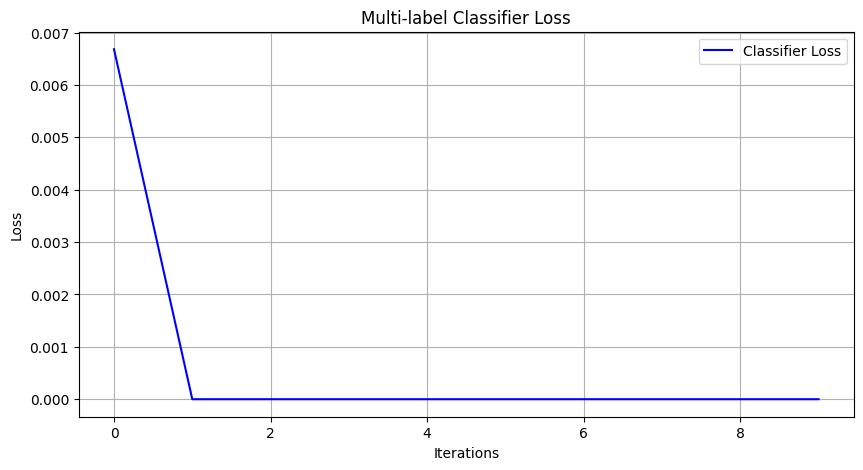

In [46]:
plot_losses(losses, accuracies, save_dir="/content/drive/My Drive/save_dir_2")

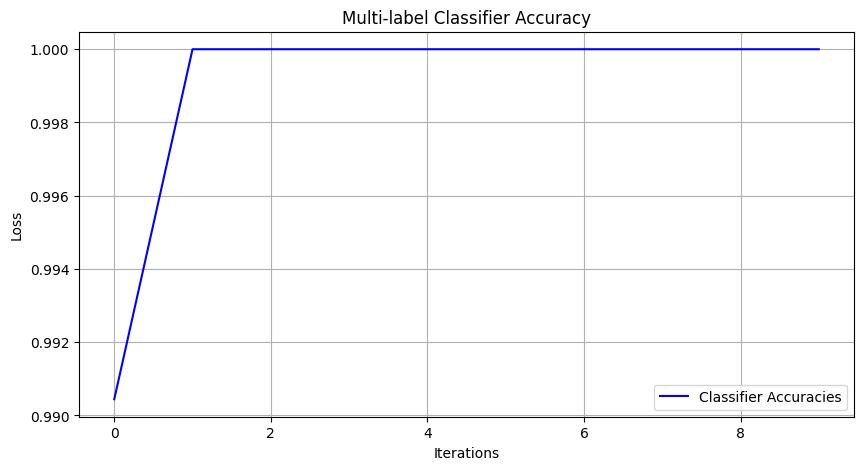

In [99]:
plot_accuracies(losses, accuracies, save_dir="/content/drive/My Drive/save_dir_2")

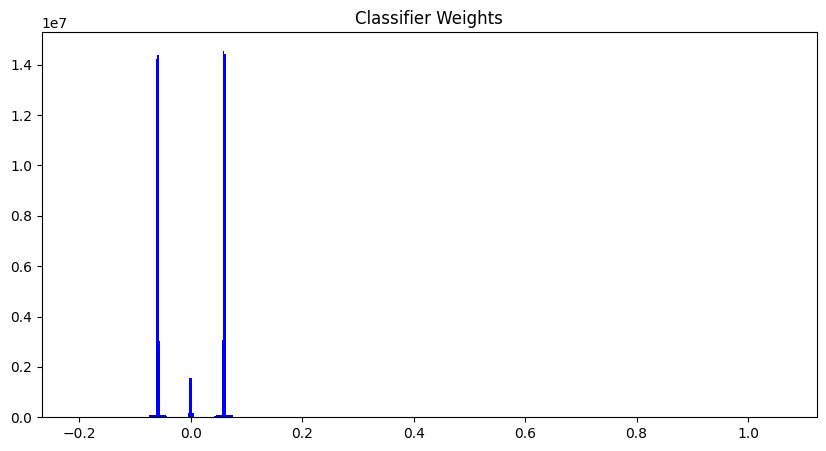

In [49]:
plot_weightss(classifier, save_dir="/content/drive/My Drive/save_dir_2")

In [50]:
def test_classifier(dataloader, classifier, device):
    classifier.eval()
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = classifier(images)
            predicted_labels.extend(outputs.cpu().detach().numpy())
            true_labels.extend(labels.cpu().detach().numpy())

    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    accuracy = accuracy_score(true_labels, (predicted_labels > 0.5).astype(int))
    print(f"Test Accuracy: {accuracy:.4f}")


# # Initialize test dataset and dataloader
test_dataset = MalariaDataset_test_data(root_dir="/content/drive/My Drive/400", mode="classification", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Test classifier
test_classifier(dataloader, classifier, device)


Test Accuracy: 1.0000


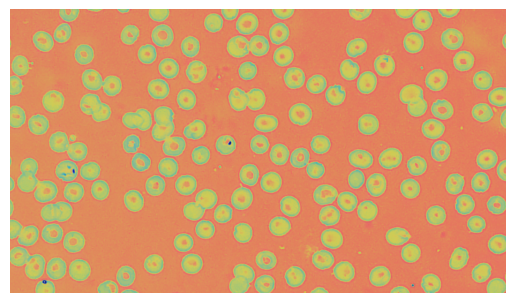

In [94]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def overlay_heatmap(image, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    # Resize the heatmap to match the dimensions of the original image
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    # Normalize the heatmap values to range [0, 1]
    heatmap_normalized = cv2.normalize(heatmap_resized, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # Apply the colormap to the heatmap
    heatmap_colored = cv2.applyColorMap(heatmap_normalized, colormap)
    # Overlay the heatmap onto the original image using alpha blending
    overlaid_image = cv2.addWeighted(image, 1-alpha, heatmap_colored, alpha, 0)
    return overlaid_image

# Example usage
# Load the original image and heatmap
original_image = cv2.imread('/content/drive/My Drive/400/HCM/train/Malaria_CM24_28Aug2021162625_0001_144.4_13.1_400x.png')
heatmap = cv2.imread('/content/drive/My Drive/400/HCM/train/Malaria_CM24_28Aug2021162625_0001_144.4_13.1_400x.png', cv2.IMREAD_GRAYSCALE)  # Assuming heatmap is grayscale

# Overlay heatmap onto the original image
result = overlay_heatmap(original_image, heatmap)

# Display the result
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## With Annotations

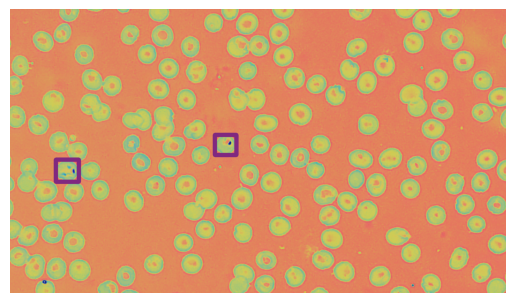

In [96]:
def overlay_heatmap(image, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    # Resize the heatmap to match the dimensions of the original image
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    # Normalize the heatmap values to range [0, 1]
    heatmap_normalized = cv2.normalize(heatmap_resized, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # Apply the colormap to the heatmap
    heatmap_colored = cv2.applyColorMap(heatmap_normalized, colormap)
    # Overlay the heatmap onto the original image using alpha blending
    overlaid_image = cv2.addWeighted(image, 1-alpha, heatmap_colored, alpha, 0)
    return overlaid_image

# Example usage
# Load the original image and heatmap
original_image = cv2.imread('/content/drive/My Drive/results/Malaria_CM24_28Aug2021162625_0001_144.4_13.1_400x.png')
heatmap = cv2.imread('/content/drive/My Drive/results/Malaria_CM24_28Aug2021162625_0001_144.4_13.1_400x.png', cv2.IMREAD_GRAYSCALE)  # Assuming heatmap is grayscale

# Overlay heatmap onto the original image
result = overlay_heatmap(original_image, heatmap)

# Display the result
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
